**Исследование пользовательского поведения покупателей в мобильном приложении "Ненужные вещи"**

В мобильном приложении "Ненужные вещи" люди продают  свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Заказчику необходимо выделить группы пользователей, которые различаются по метрикам:

retention rate,
время, проведённое в приложении,
частота действий,
конверсия в целевое действие — просмотр контактов.

- Предлагается проверить статистические гипотезы
    1. *Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Две эти группы демонстрируют разную конверсию в просмотры контактов.*
    2. *Пользователи, завершающие сессию добавлением в избранное или просмотром карты, демострируют разное удержание.* 


# Содержание



###  Предобработка данных

In [2]:
# импортируем все необходимые бибилиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from scipy import stats as st
import math as mth

### Данные о источниках получения ссылки на приложение

Прочитали  полученные для анализа данные о источниках, из которых пользователи получили ссылки на приложение 

In [3]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_sourсes.info()
mobile_sourсes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
# посмотрели имеющиеся источники
mobile_sourсes['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [5]:
# посчитали количество пользователей
mobile_sourсes['userId'].nunique()

4293

In [6]:
print('Количество пропусков  в mobile_sourсes:', mobile_sourсes.isna().sum())
print('Количество дубликатов  в mobile_sourсes:', mobile_sourсes.duplicated().sum())

Количество пропусков  в mobile_sourсes: userId    0
source    0
dtype: int64
Количество дубликатов  в mobile_sourсes: 0


4293 уникальных пользователя приходили в приложение по ссылкам из 'yandex', 'google' и "прочие". Пропусков и явных дубликатов не обнаружено. Количество уникальных пользователей совпадает с количеством строк таблицы. Название столбца 'userId' заменили на 'user_id'. 

In [7]:
mobile_sourсes = mobile_sourсes.rename(columns = {'userId':'user_id'})
mobile_sourсes.columns

Index(['user_id', 'source'], dtype='object')

### Данные о действиях пользователей в приложении

In [8]:
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
mobile_dataset.info()
mobile_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [9]:
# привели названия колонок в питоновский вид
mobile_dataset = mobile_dataset.rename(columns = {'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})
mobile_dataset.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

In [10]:
# преобразовали тип данных о времени события и уменьшили точность до целых секунд
mobile_dataset['event_time'] = mobile_dataset['event_time'].astype('datetime64[s]')
# добавили отдельную колонку с датой события
mobile_dataset['day'] = mobile_dataset['event_time'].dt.date
mobile_dataset.head()

,event_time,event_name,user_id,day
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


In [11]:
print('Количество уникальных пользователей  в mobile_dataset:', mobile_dataset['user_id'].nunique())
mobile_dataset['event_name'].unique()

Количество уникальных пользователей  в mobile_dataset: 4293


array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Количество уникальных пользователей совпадает с данными о источниках. Описание совершаемых событий:

 `advert_open` — открытие карточки объявления;
   
     `photos_show` — просмотр фотографий в объявлении;
     
     `tips_show`— пользователь увидел рекомендованные объявления;
     
     `tips_click` — пользователь кликнул по рекомендованному объявлению;
     
     `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления;
     
     `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления;
     
     `map` — пользователь открыл карту размещенных объявлений;
     
     `search_1` — `search_7` — разные события, связанные с поиском по сайту;
     
     `favorites_add` — добавление объявления в избранное.

Из описания событий можно сделать вывод о наличии неявных дубликатов: одно и то же действие "посмотреть номер телефона" может быть обозначено двумя способами `contacts_show` или `show_contacts`, необходимо их объединить. 

Различные действия в процессе поиска по сайту `search_1` — `search_7` посчитали возможным объединить в одно действие - поиск `search`, при этом руководствовались тем, что нюансы способов поиска на данном этапе заказчика не интересуют.

Сведения о факте звонка пользователя по карточке объявления `contacts_call` не являются полными, так как  звонок зачастую может осуществляться не через приложение, данные об этом событии сочли целесообразным ислючить из рассмотрения.

In [12]:
# убрали неявные дубликаты: заменили `show_contacts` на `contacts_show`  
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('show_contacts', 'contacts_show')
#объединили все 7 событий поиска по приложению в одно событие поиска 'search'
duplicates = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7',] # список неправильных имён
name = 'search' # правильное имя
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace(duplicates, name) # замена всех значений из duplicates на name
#избавились от событий `contacts_call`, так как сведения о них не могут быть полными и конверсия в звонки не интерисует заказчика
mobile_dataset = mobile_dataset.query('event_name != "contacts_call"')
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add'], dtype=object)

In [13]:
print('Количество пропусков  в mobile_dataset:', mobile_dataset.isna().sum())
print('Количество дубликатов  в mobile_dataset:', mobile_dataset.duplicated().sum())

Количество пропусков  в mobile_dataset: event_time    0
event_name    0
user_id       0
day           0
dtype: int64
Количество дубликатов  в mobile_dataset: 1217


In [14]:
# Явные дубликаты образовались в результате округления времени и работы с названиями действий 
print('Доля дубликатов в данных о событиях', mobile_dataset.duplicated().sum()/mobile_dataset.shape[0])

Доля дубликатов в данных о событиях 0.01652275442598023


In [15]:
#Удалили образовавшиеся дубликаты, их доля меньше  2% 
mobile_dataset = mobile_dataset.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов  в mobile_dataset:', mobile_dataset.duplicated().sum())

Количество дубликатов  в mobile_dataset: 0


In [16]:
# проверили, что в результате удаления дубликатов не потеряли уникальных пользователей
print('Количество уникальных пользователей  в mobile_dataset:', mobile_dataset['user_id'].nunique())

Количество уникальных пользователей  в mobile_dataset: 4293


In [17]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72439 entries, 0 to 72438
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  72439 non-null  datetime64[ns]
 1   event_name  72439 non-null  object        
 2   user_id     72439 non-null  object        
 3   day         72439 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB


In [18]:
# объединили обе таблицы
mobile = mobile_dataset.merge(mobile_sourсes)
mobile.head()

,event_time,event_name,user_id,day,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
3,2019-10-07 00:01:27,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:01:34,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other


**Вывод**

Подготовили для дальнейшего исследования данные о поведении 4239 пользователей (покупателей) и источниках их привлечения в приложение "Ненужные вещи". После подготовки данных имеем  72439 событий. Из наименований событий следует, что это данные о поведении потенциальных покупателей.

Подготовка данных включала в себя следующие операции:

- изменили названия колонок;
- проверили пропуски, пропущенные значения в таблицах не обнаружили;
- дубликатов в данных о источниках скачивания приложения не обнаружили; 
- преобразовали тип данных о времени события из objec в datetime64[ns] и округлили время до целых секунд;
- создали дополнительную колонку day, содержащую сведения только о дате события;
- унифицировали названия событий "посмотреть номер телефона";
- унифицировали все события о поиске по сайту 'search' вместо набора `search_1` — `search_7`;
- исключили строки с событиями `contacts_call` — "пользователь позвонил по номеру телефона на карточке объявления", как неполные;
- удалили 1217 строк дубликатов в данных о событиях, которые сформировались в результате округления времени события и унификации названий событий.

## Исследовательский анализ данных

Оценили длительность периода сбора данных, нашли минимальное и максимальное время.

In [19]:
print(mobile['event_time'].min(), mobile['event_time'].max())


2019-10-07 00:00:00 2019-11-03 23:58:12


In [20]:
# каждый ли день были события
mobile['day'].nunique()

28

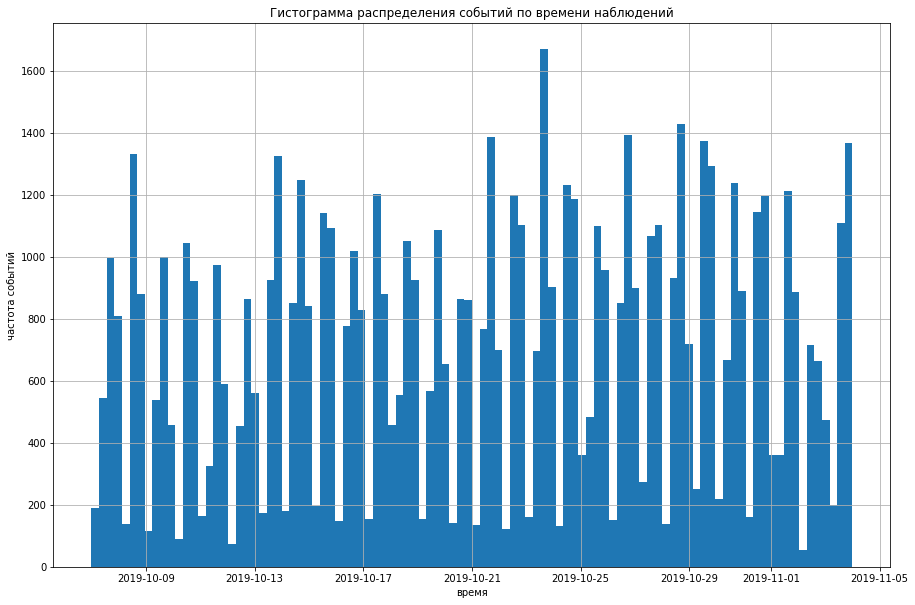

In [21]:
# построили гистограмму распределения событий по времени
mobile['event_time'].hist(bins=100, figsize=(15,10))
plt.title('Гистограмма распределения событий по времени наблюдений')
plt.xlabel('время')
plt.ylabel('частота событий')
plt.show();

In [22]:
print('среднее количество событий на одного пользователя', mobile.shape[0]/mobile['user_id'].nunique())

print('Среднее количество событий на одного пользователя в день', mobile.shape[0]/mobile['user_id'].nunique()/mobile['day'].nunique())

среднее количество событий на одного пользователя 16.873747961798276
Среднее количество событий на одного пользователя в день 0.6026338557785099


События достаточно равномерно распределены в течение 28 суток, с 00 часов 7 октября до полуночи 3 ноября 2019 года. Активность пользователей демонстрирует понятные суточные колебания, но даже ночью некоторые ищут ненужные вещи.  В среднем один пользователь за все время совершил примерно 17 действий, то есть меньше одного действия в день. Не каждый день заходят выбрать ненужные вещи.

In [23]:
# посчитали количество событий, совершенных каждым пользователем
ec = mobile.groupby('user_id')['event_name'].count().sort_values().reset_index()
ec

,user_id,event_name
0,a328c7d1-ff5b-41df-822a-bccb105fb408,1
1,df7e87b9-5aed-42f0-bcad-e4dabb4c902d,1
2,11c4e5be-6d55-4c4b-b207-3fa7a5e5b9bf,1
3,3a13ffa6-7231-4688-ad96-9c8334e9ed0e,1
4,8bc67b38-7e6d-4084-b354-58b30d8f1e6d,1
...,...,...
4288,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,396
4289,21230dd9-2f7f-4b77-a436-43d4d10388e0,398
4290,9ce63488-758a-481a-bcb5-a02b467e1d84,406
4291,e13f9f32-7ae3-4204-8d60-898db040bcfc,463


Обнаружили пользователей, совершивших за весь период только одно событие, скорее всего случайно ткнули пальцем в экран и попали на приложение.

In [24]:
# посмотрели распределение пользователей по количеству совершенных ими событий 
ec.groupby('event_name')['user_id'].count().sort_values().tail(10)

event_name
12    144
11    150
3     168
10    178
9     199
8     245
7     301
6     358
4     392
5     479
Name: user_id, dtype: int64

Большинство пользователей совершили от 5 до 12 ссобытий в приложении за 28 дней

In [25]:
# количество пользователей, совершавших различные действия
users_event = mobile.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
users_event 

,user_id
event_name,
tips_show,2801
search,1666
map,1456
photos_show,1095
contacts_show,981
advert_open,751
favorites_add,351
tips_click,322


Из таблицы видно, что всем агрессивно показывают рекомендованные оъявления, но мало кто их открывает, пользователи предпочитают искать в приложении именно то, за чем пришли. 

### Определение длительности сессии.

Одной сессией считаем все события, совершенные пользователем в течение суток. Чтобы определить продолжительность сессии, определили время первого и последнего события за день и посчитали разницу между ними в секундах, сгруппировав сведения по пользователям и дням. Включили в сводную таблицу сведения о первом и последнем событии, а также количестве событий за день.

In [26]:
mobile_df = mobile.groupby(['user_id','day']).agg({'event_time':['min', 'max'], 'event_name':['first', 'last', 'count']}).reset_index()
mobile_df.columns = ['user_id','session', 'start', 'finish', 'first_event', 'last_event', 'count_event']
mobile_df['interval'] = (mobile_df.finish - mobile_df.start).dt.total_seconds()
mobile_df.info()
mobile_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      7817 non-null   object        
 1   session      7817 non-null   object        
 2   start        7817 non-null   datetime64[ns]
 3   finish       7817 non-null   datetime64[ns]
 4   first_event  7817 non-null   object        
 5   last_event   7817 non-null   object        
 6   count_event  7817 non-null   int64         
 7   interval     7817 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 488.7+ KB


,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,596.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,507.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,tips_show,tips_show,14,900.0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,map,tips_show,8,758.0
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,search,photos_show,9,1521.0
5,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,2019-10-20 18:49:24,2019-10-20 20:05:36,search,photos_show,15,4572.0
6,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-24,2019-10-24 10:50:40,2019-10-24 10:57:12,photos_show,photos_show,9,392.0
7,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,2019-10-29 21:18:24,2019-10-29 22:10:25,search,photos_show,18,3121.0
8,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-30,2019-10-30 07:50:45,2019-10-30 08:26:53,search,contacts_show,14,2168.0
9,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,2019-11-03 17:12:09,2019-11-03 17:12:09,contacts_show,contacts_show,1,0.0


Обнаружили сессии длительностью меньше секунды, в которых совершено одно действие. Удалили эти случайные сессии, так как они не характеризуют поведение пользователей.

In [27]:
mobile_df = mobile_df.query('count_event > 1 and interval !=0')
mobile_df

,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,596.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,507.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,tips_show,tips_show,14,900.0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,map,tips_show,8,758.0
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,search,photos_show,9,1521.0
...,...,...,...,...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47,2019-10-29 16:13:00,tips_show,contacts_show,20,8053.0
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-30,2019-10-30 00:15:43,2019-10-30 11:31:45,contacts_show,tips_show,3,40562.0
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31,2019-11-01 00:24:53,tips_show,tips_show,2,22.0
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,2019-11-02 01:16:48,2019-11-02 19:30:50,tips_show,tips_show,7,65642.0


In [28]:
# посмотрели, как распределены сессии по количеству событий
mobile_df['count_event'].sort_values()

4100      2
4659      2
6322      2
4730      2
7481      2
       ... 
5880    114
5219    116
5304    127
5881    169
4744    383
Name: count_event, Length: 6781, dtype: int64

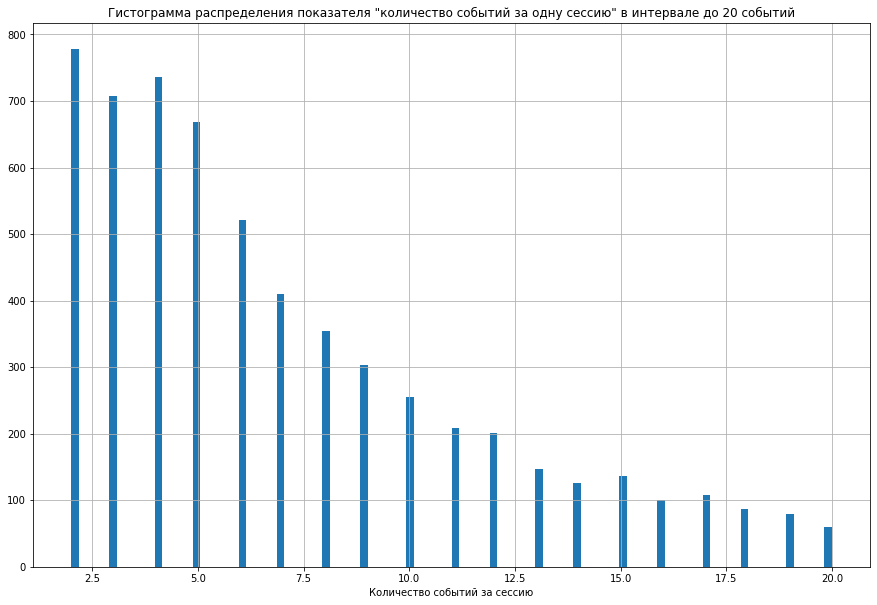

In [29]:
mobile_df['count_event'].hist(bins=100, figsize=(15,10), range=[2, 20])
plt.title('Гистограмма распределения показателя "количество событий за одну сессию" в интервале до 20 событий')
plt.xlabel('Количество событий за сессию')

plt.show();

Количество событий за одну сессиию резко снижается в интервале от 2 до 10 событий и затем плавно приближается к нулю.

In [30]:
# как распределены сессии по длительности 
mobile_df['interval'].sort_values()

2980        1.0
1924        1.0
2862        1.0
3064        1.0
6753        1.0
         ...   
7247    82803.0
5531    83173.0
6144    84426.0
5663    84644.0
660     85048.0
Name: interval, Length: 6781, dtype: float64

In [31]:
#сколько действий и какие производят за 3 секунды?
mobile_df.query('interval <= 3').sort_values(by='interval')

,user_id,session,start,finish,first_event,last_event,count_event,interval
2980,628d9787-fc29-42f8-8aaf-2e7b0d9e1d4a,2019-10-29,2019-10-29 20:08:27,2019-10-29 20:08:28,photos_show,photos_show,2,1.0
2862,5e3b6d59-ccbf-4247-9946-be64a2be4a53,2019-10-23,2019-10-23 11:14:43,2019-10-23 11:14:44,photos_show,photos_show,2,1.0
2803,5ca3716b-928f-43df-80e4-590c4e20bea2,2019-10-11,2019-10-11 20:51:16,2019-10-11 20:51:17,photos_show,photos_show,2,1.0
2503,515e9d9f-a690-4a30-8b05-b948d267e538,2019-10-17,2019-10-17 12:36:28,2019-10-17 12:36:29,tips_show,contacts_show,2,1.0
3064,646c46f9-bc2f-4448-901f-8cc0e8318d8c,2019-10-25,2019-10-25 09:04:50,2019-10-25 09:04:51,photos_show,photos_show,2,1.0
1924,3ce3b06f-3647-48d2-9c4e-d72362a389d4,2019-10-15,2019-10-15 23:37:33,2019-10-15 23:37:34,photos_show,photos_show,2,1.0
2380,4c38c011-e7d4-47a2-9da3-35888e0606b8,2019-10-22,2019-10-22 21:52:54,2019-10-22 21:52:55,photos_show,photos_show,2,1.0
6753,db9e4705-ca1b-44f2-b94e-821fb1387c5c,2019-10-09,2019-10-09 02:34:38,2019-10-09 02:34:39,search,search,2,1.0
811,16a5371c-152f-48d8-86fe-5636a931316b,2019-11-03,2019-11-03 22:40:59,2019-11-03 22:41:01,tips_show,tips_show,3,2.0
6087,c81944b3-3642-4c5d-8408-9e401263cc53,2019-10-12,2019-10-12 11:30:24,2019-10-12 11:30:26,search,search,2,2.0


Поразительно! За 1 секунду некоторые успевают посмотреть рекомендуемое предложение и посмотреть номер телефона на карточке. Оставим этих виртуозов для рассмотрения. 

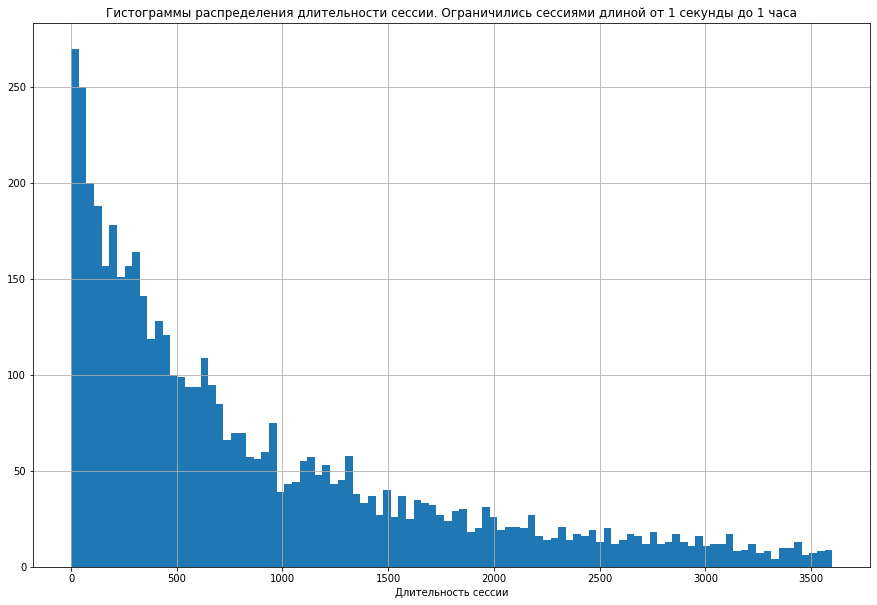

In [32]:
# Распределние длительности сессий в интервале от 1 секунды до 1 часа
mobile_df['interval'].hist(bins=100, figsize=(15,10), range=[1, 3600])
plt.title('Гистограммы распределения длительности сессии. Ограничились сессиями длиной от 1 секунды до 1 часа')
plt.xlabel('Длительность сессии')

plt.show();

Максимальное количество сессий приходится на  интервал от 1 секунды до 17 минут, затем плавно приближается к нулю.  

Посмотрели на взаимосвязь продолжительности сессии и количества совершенных в них событий, для этого построили диаграмму рассеяния

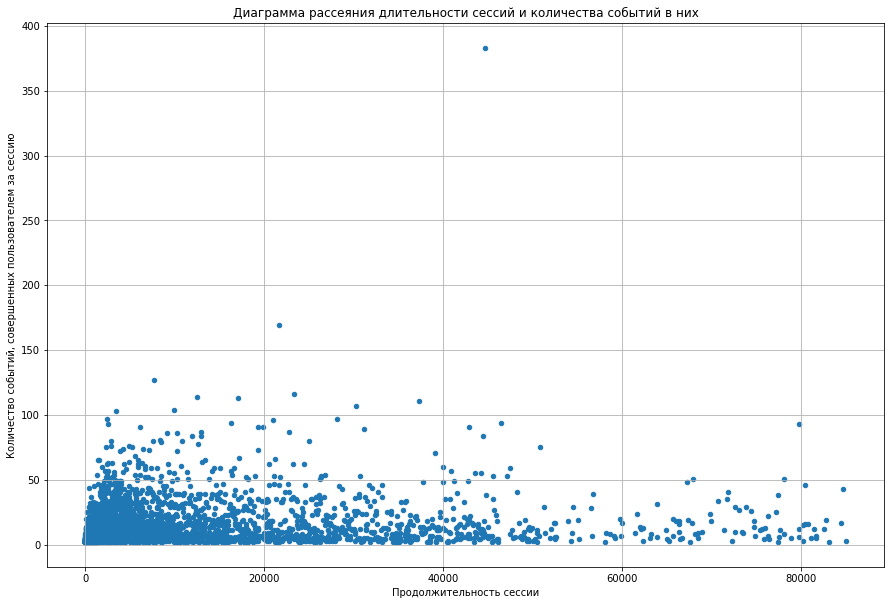

In [33]:
# диаграмма рассеяния длительности сессий и количества событий в них

mobile_df.plot(x="interval", y="count_event", kind="scatter", grid=True, figsize=(15,10))
plt.title('Диаграмма рассеяния длительности сессий и количества событий в них')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Количество событий, совершенных пользователем за сессию')
plt.show();

In [34]:
# посмотрели сессиию, за время которой совершено аномально большое количество действий
mobile_df.query('count_event==383')

,user_id,session,start,finish,first_event,last_event,count_event,interval
4744,9ce63488-758a-481a-bcb5-a02b467e1d84,2019-10-08,2019-10-08 10:47:17,2019-10-08 23:12:00,tips_show,tips_show,383,44683.0


В общем виде  рост продолжительности сессии не приводит к увеличению количества совершенных внутри неё событий. Бурная деятельность наблюдается на коротких сессиях. Бросается в глаза очевидный выброс: сессия длительностью 44683 секунды (больше 12 часов), во время которой совершено 383 события. Человек  в течение 12 часов каждые 2 минуты взаимодействовал с приложением. Это опасный человек. Мы его удалим.

На распределении продолжительности сессий видно, что количество сессий длиннее одного часа медленно приближается к нулю. Есть сессия длительностью более 23 часов в сутки. Пользователь, скорее всего, открыл приложение и забыл его закрыть, или посмотрел утром, потом ещё раз посмотрел вечером или почти через сутки, но по принятому нами допущению всё время между двумя заходами будет включено в одну сессию. К счастью, таких аномально длинных сессий немного. Чтобы определить границу безболезненного отсечения сверхдлинных сессий, нашли перцентили длины сессий.

In [35]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(mobile_df['interval'], [95, 99]))

[32296.  65110.8]


Только 5% пользователей проводят в приложении больше 32296 секунд (около 9 часов). Вполне может быть, что заглянул утром, потом ещё раз вечером. 

Сверхкороткие (меньше секунды) сессии с одним событием в количестве 1036 штук мы уже отбросили.

Исключаем из рассмотрения сессии длиннее 32296 секунд, сюда же попадает сессия с аномальным количеством событий.

In [36]:
# получили таблицу с данными, очищенными от случайных безинформативных сессий
mobile_df = mobile_df.query('interval < 32296')
mobile_df.head()

,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,596.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,507.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,tips_show,tips_show,14,900.0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,map,tips_show,8,758.0
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,search,photos_show,9,1521.0


In [37]:
# посчитали долю исключенных из исследования пользователей
print(mobile_df['user_id'].nunique())
print(mobile['user_id'].nunique())
print(1 - (mobile_df['user_id'].nunique()/mobile['user_id'].nunique()))

4144
4293
0.03470766363848121


**Вывод**

В целях данного исследования установили, что один день, в который поьзователь заходил в приложение, является одной сессией. 

Длительность сессии определили как разницу между временем первого и последнего события за сутки. Слабым местом этого допущения является то, что человек мог зайти в приложение несколько раз за сутки, тогда длительность сессии оказывается завышенной. Однако, с учетом того, что подавляющее большинство сессий длятся в пределах одного часа, надеемся, что принятое допущение не окажет существенного влияния на результат исследования.

Дополнили данные из лога сведениями о количестве событий в сессии и продолжительности сессий.

Выявили и исключили из рассмотрения сессии из одного события длительностью менее секунды.

Исключили аномально длинные сессии (больше 9 часов), пятипроцентную границу длительности сессии определили методом np.percentile().

Таким образом, исключив из рассмотрения аномально короткие и аномально длинные сессии, сократили список пользователей всего на 3,5%. 

## Разделение пользователей на группы

Исходя из предположения, что среднее время, проводимое пользователем в приложении в течение одного дня, характеризует его интерес к приложению и умение им пользоваться, решили разделить пользователей на категории по средней продолжительности сессии.

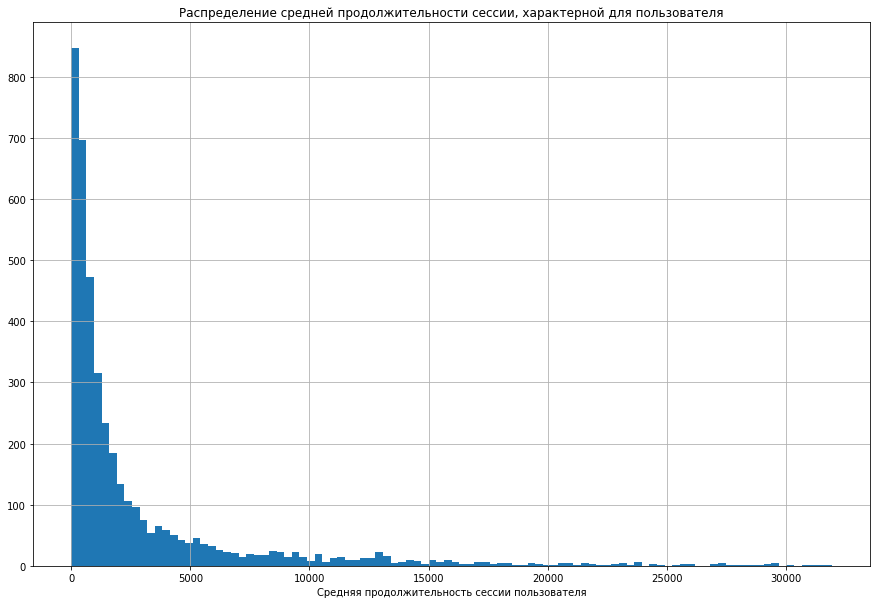

In [39]:
# гистограмма распределения средней продолжительности сессии для каждого пользователя
df_sort['interval_mean'].hist(bins=100, figsize=(15,10))
plt.title('Распределение средней продолжительности сессии, характерной для пользователя')
plt.xlabel('Средняя продолжительность сессии пользователя')

plt.show();

Среди пользователей есть шустрики и есть тугодумы. Посмотрели распределение средних значений продолжительности сессий для каждого пользователя методом describe().

In [40]:
df_sort.describe()

,interval_mean
count,4144.000000
mean,2890.598708
std,4710.973733
min,1.000000
25%,399.000000
50%,1016.500000
75%,2948.750000
max,31924.000000


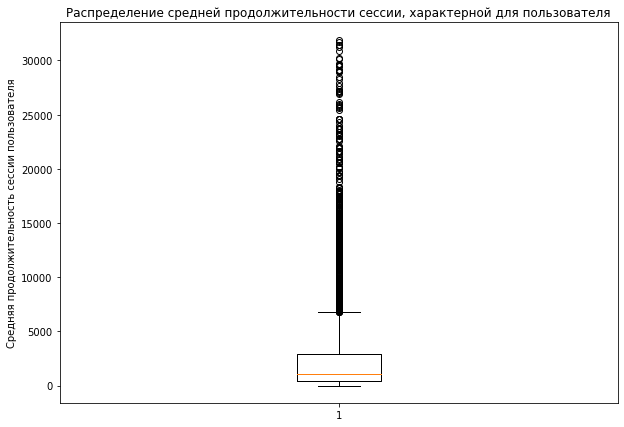

In [41]:
# и в графическом виде распределение средних значений продолжительности сессий для пользователя.
fig =  plt.figure(figsize =(10,7 )) 
plt.boxplot(df_sort['interval_mean'])
plt.title('Распределение средней продолжительности сессии, характерной для пользователя')

plt.ylabel('Средняя продолжительность сессии пользователя')

plt.show()

Распределение сильно смещено в сторону меньших значений, медиана приближена к первому квартилю и имеется длинный постепенно редеющий "хвост" выбросов, превышающих верхний ус.

**Определили на основании статистических данных и графика границы разделения пользователей на группы, по возможности соблюдая равномерность.**


От нижнего уса до первого квартиля. Для 25% пользователей средняя продолжительность сессии не превышает 399 секунд (6,65 минут) назовем их  быстрыми `fast`. 

От первого квартиля до медианы. Следующая группа из 25% пользователей проводит в приложении в среднем от 399 секунд до  1016,5 секунд (от 6,65 до 16,94 минут) в день, назовём их деловыми  `business`. 

От медианы до третьего квартиля. Потенциальные покупатели, которые в среднем тратят в день на приложение от 1016,5 секунд до 2948,75 секунд (от 16,94 минут до 49,1 минут),пусть будут серьёзными `serious`. 

От третьего квартиля 2948,75 секунд (49,1 минуты) до конца максимального значения, назовём пользователей медленными `slow`. 


Получается 4 категории пользователей.

Границы категорий округлим до удобных к восприятию значений:
 - до 7 минут (420 секунд) `fast`;
 - от 7 до 17 минут(421 - 1020 секунд) `business`;
 - от 17 минут до 50 минут (1021 - 3000 секунд) `serious`;
 - больше 50 минут  (3001 )`slow`;
 

In [42]:
# функция для категоризации пользователей по значению средней продолжительности сессии
def user_cat(df_sort):
    if df_sort['interval_mean'] < 420:
        return 'fast'
    if 421 < df_sort['interval_mean'] < 1020:
        return 'business'
    if 1021 < df_sort['interval_mean'] < 3000:
        return 'serious'
    return 'slow'
    
 
df_sort['user_cat'] = df_sort.apply(user_cat, axis=1) # применили функцию  к таблице
df_sort['user_cat'].value_counts()

fast        1080
serious     1045
slow        1032
business     987
Name: user_cat, dtype: int64

In [43]:
print(df_sort['user_id'].nunique())
df_sort.head(10)

4144


,user_id,interval_mean,user_cat
0,4c38c011-e7d4-47a2-9da3-35888e0606b8,1.000000,fast
1,16a5371c-152f-48d8-86fe-5636a931316b,2.000000,fast
2,fcf065b5-ccb4-4d83-bded-8a759b4022fd,2.333333,fast
3,0bb1cfac-5a00-4677-88d0-d41929e5ad7c,3.000000,fast
4,d9b53b3f-bb75-4424-a474-da491f0a6501,3.000000,fast
5,516afefe-f606-4692-81e1-16c200a81b7c,3.000000,fast
6,48bbd3fe-c8b4-4caf-83bb-4bb3f3f68182,3.000000,fast
7,5d0f21d7-7af5-4e14-b63e-cad5e0c324ea,4.000000,fast
8,b088c790-c70b-473c-a774-7f440365aa82,4.000000,fast
9,7f364c04-f996-4ed6-89d0-ffbe627920ab,4.000000,fast


In [44]:
# добавили к общей таблице сведения о категории пользователя

mobile = mobile.merge(df_sort[['user_id', 'user_cat']])
print(mobile['user_id'].nunique())

mobile.head()

4144


,event_time,event_name,user_id,day,source,user_cat
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,serious
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,serious
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,serious
3,2019-10-07 00:01:27,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,serious
4,2019-10-07 00:01:34,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,serious


In [45]:
# добавили признак категории к рабочей таблице 
mobile_df = mobile_df.merge(df_sort[['user_id', 'user_cat']])
mobile_df

,user_id,session,start,finish,first_event,last_event,count_event,interval,user_cat
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,596.0,business
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,507.0,business
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,tips_show,tips_show,14,900.0,business
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,map,tips_show,8,758.0,business
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,search,photos_show,9,1521.0,serious
...,...,...,...,...,...,...,...,...,...
6436,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-27,2019-10-27 14:46:59,2019-10-27 20:00:53,tips_show,contacts_show,17,18834.0,slow
6437,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-28,2019-10-28 11:49:38,2019-10-28 15:15:51,tips_show,contacts_show,7,12373.0,slow
6438,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47,2019-10-29 16:13:00,tips_show,contacts_show,20,8053.0,slow
6439,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31,2019-11-01 00:24:53,tips_show,tips_show,2,22.0,slow


In [46]:
# посчитали количество событий, количество пользователей и среднее количество событий на 
# одного пользователя для каждой категории
user_category = mobile.pivot_table(index = 'user_cat', aggfunc = {
    'event_name': 'count',
    'user_id' : 'nunique',}).reset_index()                   
# посчитали среднее количество событий на одного пользователя для каждой категории
user_category['event_mean_count']  = (user_category['event_name']/ user_category['user_id']).round()
# переименовали колонки
user_category.columns = ['user_cat', 'event_count', 'user_count', 'user_event_count']
user_category = user_category.sort_values(by='user_event_count')
user_category

,user_cat,event_count,user_count,user_event_count
1,fast,6802,1080,6.0
0,business,10766,987,11.0
2,serious,19291,1045,18.0
3,slow,34487,1032,33.0


Никаких неожиданностей, чем дольше сидят в приложении, тем больше успевают совершить действий

Проверили, как различается по категориям пользовательская активность — количество уникальных активных пользователей за определённое время.
DAU — количество уникальных пользователей в день, этого достаточно, чтобы оценить различия поведения  пользователей различных категорий. Активность за неделю или месяц не стали оценивать. 

In [47]:
# для всех пользователей
dau_total = (mobile.groupby('day').agg({'user_id': 'nunique'}).mean().round())
dau_total


user_id    272.0
dtype: float64

In [48]:
# только быстрые
dau_fast = (mobile.query('user_cat == "fast"').groupby('day').agg({'user_id': 'nunique'}).mean())
dau_fast

user_id    59.357143
dtype: float64

In [49]:
# только деловые
dau_business = (mobile.query('user_cat == "business"').groupby('day').agg({'user_id': 'nunique'}).mean())
dau_business

user_id    54.892857
dtype: float64

In [50]:
# только серьёзные
dau_serious = (mobile.query('user_cat == "serious"').groupby('day').agg({'user_id': 'nunique'}).mean())
dau_serious

user_id    61.107143
dtype: float64

In [51]:
# только медленные
dau_slow = (mobile.query('user_cat == "slow"').groupby('day').agg({'user_id': 'nunique'}).mean())
dau_slow

user_id    96.464286
dtype: float64

Добавили колонку DAU для каждой категории в таблицу `user_category`

In [52]:
user_category['dau']  = [
    (int(dau_fast)), (int(dau_business)), (int(dau_serious)), (int(dau_slow))
]
user_category

,user_cat,event_count,user_count,user_event_count,dau
1,fast,6802,1080,6.0,59
0,business,10766,987,11.0,54
2,serious,19291,1045,18.0,61
3,slow,34487,1032,33.0,96


Хотя DAU называют "метрикой тщеславия", за то что она мало чувствительна к изменениям в продукте и, как правило, всегда растёт, нам она подтверждает правильность выбранного критерия для категоризации пользователей на основании среднего времени, проводимого человеком в приложении за одно посещение. Разделяя пользователей на категории мы сформировали группы примероно одинакокой численности, приблизительно 1000 человек, отклонения объясняются тем, что мы отступили от границ перцентилей, чтобы границы разделения групп были более удобны для восприятия. 

Больше всего пользователей в день составляют те, кто проводит в приложении больше 50 минут за сессию. 

Остальные группы представлены каждый день равномерно.

**Выводы**

Разделили пользователей приложения "Ненужные вещи" на 4 категории, исходя из характерного для пользователя времени, которое он проводит в приложении за одно посещение. Сделали допущение, что одно посещение равно одним суткам. Постарались распределить пользователей по группам равномерно, примерно 1000 человек.  

Установили следующие границы для разделения на группы:
 - "Быстрые" до 7 минут (420 секунд) `fast`;
 - "Деловые" от 7 до 17 минут(421 - 1020 секунд) `business`;
 - "Серьёзные" от 17 минут до 50 минут (1021 - 3000 секунд) `serious`;
 - "Медленные" от 50 минут (3001 секунда)`slow`. 

## Ответы на вопросы заказчика

### Какие пользователи склонны часто возвращаться в мобильное приложение.

Чем большее дней, когда пользователь заходил в приложение, тем больше он склонен возвращаться. Посчитали количество посещений для каждого пользователя.

In [53]:
df_day = mobile.groupby(['user_cat', 'user_id']).agg({'day':'nunique'}).reset_index().sort_values(by='day')
df_day

,user_cat,user_id,day
2071,serious,00b59e77-3dc8-4193-a217-c50b9fe849bf,1
2241,serious,22588646-6cb5-4a86-af6e-b14b1ff4179a,1
2242,serious,226f0c0a-145a-42b6-89d4-a5ce49fddbb3,1
2243,serious,22a038dd-c03d-4717-bca1-f990dec2dcda,1
3993,slow,db10ec58-2287-4e77-a281-8194ef558441,1
...,...,...,...
3505,slow,6383ff6a-04b8-4562-a98f-bb4f760d3c39,18
3189,slow,1580911b-65db-4f1a-be7e-1ca39becac30,18
3603,slow,7e797355-265c-4997-ba47-2258e06d3c66,21
3158,slow,0d9e5bb7-0ad6-4b62-a118-b1e4f5b31dfa,21


Количество посещений приложения одним пользователем за исследуемый период составляет от 1 до 25 раз

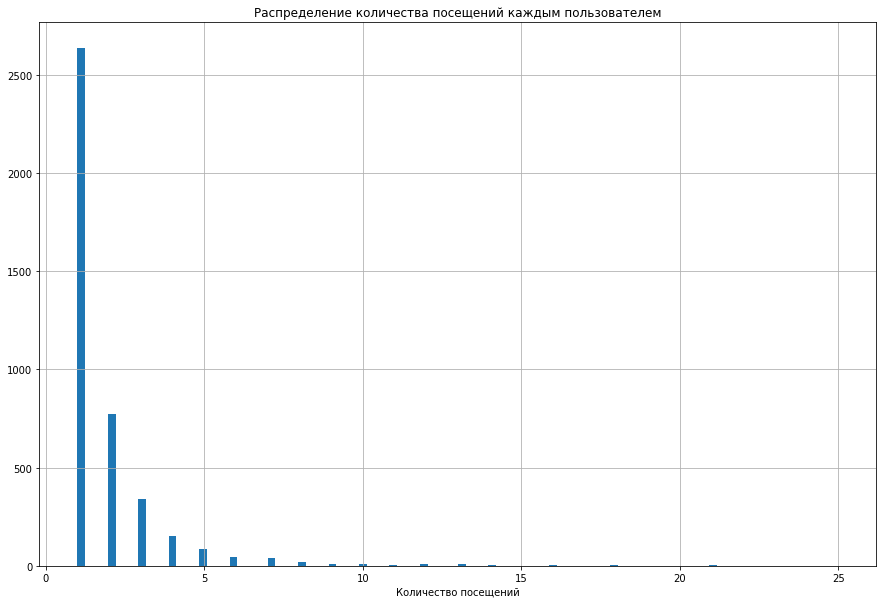

In [54]:
# гистограмма распределения количества сессий за исследуемый период
df_day['day'].hist(bins=100, figsize=(15,10))
plt.title('Распределение количества посещений каждым пользователем')
plt.xlabel('Количество посещений')

plt.show();

Пользователи, которые заходили в приложение 1 раз за исследуемый период, составляют подавляющее большинство. Но нашелся покупатель, который искал ненужные вещи 25 дней из 28. Чтобы ответить на вопрос заказчика: "Какие пользователи склонны часто возвращаться в мобильное приложение?" построили распределение количества сессий для каждой категории.

In [55]:
# повернули таблицу, чтобы категории стали колонками
df_d = df_day.pivot_table(index = 'day', columns = 'user_cat', values = 'user_id', aggfunc = 'nunique')
df_d.fillna(0) 

user_cat,business,fast,serious,slow
day,,,,
1,697.0,736.0,723.0,480.0
2,161.0,211.0,163.0,238.0
3,68.0,78.0,83.0,110.0
4,34.0,33.0,35.0,52.0
5,12.0,10.0,19.0,44.0
6,7.0,5.0,5.0,27.0
7,4.0,5.0,6.0,24.0
8,0.0,0.0,4.0,16.0
9,0.0,1.0,2.0,5.0


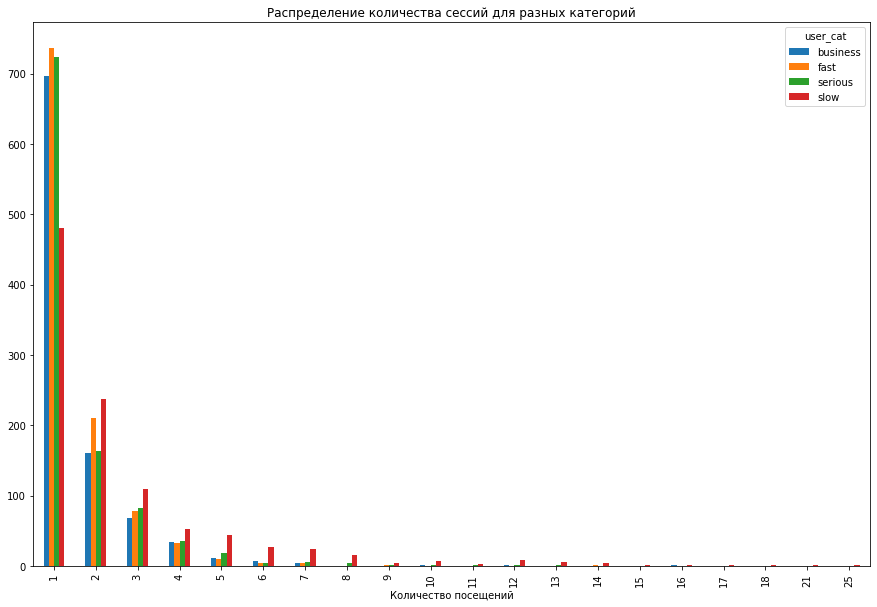

In [56]:
# построили столбчатую диаграмму распределения количество сессиий для разных категорий
plt.rcParams["figure.figsize"] = (15, 10)
#plt.figure(figsize=(15, 10))
df_d.plot.bar()
plt.title('Распределение количества сессий для разных категорий')
plt.xlabel('Количество посещений')

plt.show();

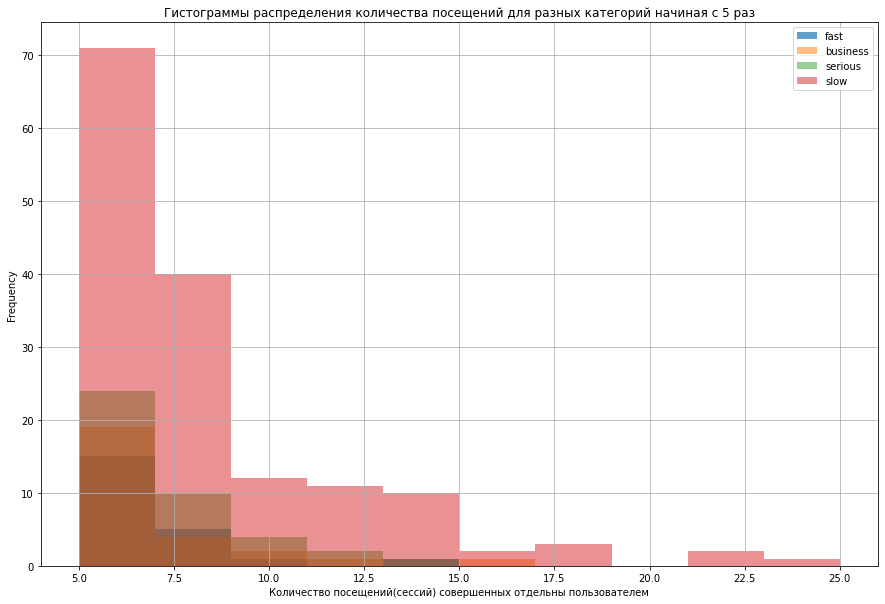

In [57]:
# построили совместные гистограммы
ax = df_day.query('user_cat == "fast"')['day'].plot(kind='hist', range=(5, 25), alpha=0.7, label='fast', legend=True, figsize=(15, 10))
df_day.query('user_cat == "business"')['day'].plot(kind='hist', range=(5, 25), alpha=0.5, label='business', ax=ax, grid=True, legend=True)
df_day.query('user_cat == "serious"')['day'].plot(kind='hist', range=(5, 25), alpha=0.5, label='serious', ax=ax, grid=True, legend=True)
df_day.query('user_cat == "slow"')['day'].plot(kind='hist', range=(5, 25), alpha=0.5, label='slow', ax=ax, grid=True, legend=True)
plt.title('Гистограммы распределения количества посещений для разных категорий начиная с 5 раз')
plt.xlabel('Количество посещений(сессий) совершенных отдельны пользователем')
plt.show()

Из таблицы и графиков видно, что часто возвращаться склонны медленные пользователи, те кто проводит в приложении больше 50 минут в день.

Проверили этот вывод рассчитав удержание (retention) для всех категорий пользователей. Для этого создали профили пользователей, рассчитали удержание и построили график. Горизонт анализа определили 7 дней.

In [58]:
# функция для создания пользовательских профилей 

def get_profiles(mobile):

    # находим параметры первых посещений
    profiles = (
        mobile.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg(
            {
                'event_time': 'first',
                'source': 'first',
                'user_cat': 'first',
                'event_name': 'first',
            }
        )
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    profiles['dt'] = profiles['first_ts'].dt.date
    
    
    return profiles

In [59]:
# применили функцию к данным mobile и сформировали профили пользователей
profiles = get_profiles(mobile)
profiles

,user_id,first_ts,source,user_cat,event_name,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,other,business,tips_show,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33,yandex,serious,search,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,serious,photos_show,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05,google,business,search,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,business,contacts_show,2019-10-25
...,...,...,...,...,...,...
4139,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,yandex,serious,map,2019-10-13
4140,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49,yandex,fast,photos_show,2019-10-07
4141,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,google,fast,tips_show,2019-10-23
4142,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33,yandex,business,search,2019-10-21


In [60]:
# задали момент  и горизонт аналза
min_analysis_date = profiles['first_ts'].min()
observation_date =  profiles['first_ts'].max()
print('Самая рання дата посещения сайта - минимальная дата привлечения пользователей:', min_analysis_date)
print('Самая поздняя дата посещения сайта:',  observation_date)
horizon_days = 7 
max_analysis_date = observation_date - timedelta(days=horizon_days-1) 

print('Максимальная дата привлечения пользователей:',  max_analysis_date)

Самая рання дата посещения сайта - минимальная дата привлечения пользователей: 2019-10-07 00:00:00
Самая поздняя дата посещения сайта: 2019-11-03 23:46:47
Максимальная дата привлечения пользователей: 2019-10-28 23:46:47


In [61]:
# функция для рассчета удержания произвольных когорт
def get_retention(
    profiles,
    mobile_df,
    observation_date,
    horizon_days,
    dimensions=[],  
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        mobile_df[['user_id', 'start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание с dimensions
    result_grouped = result_raw.pivot_table(
        index=dimensions,  # заменили dt
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  # заменили dt
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  # заменили dt
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

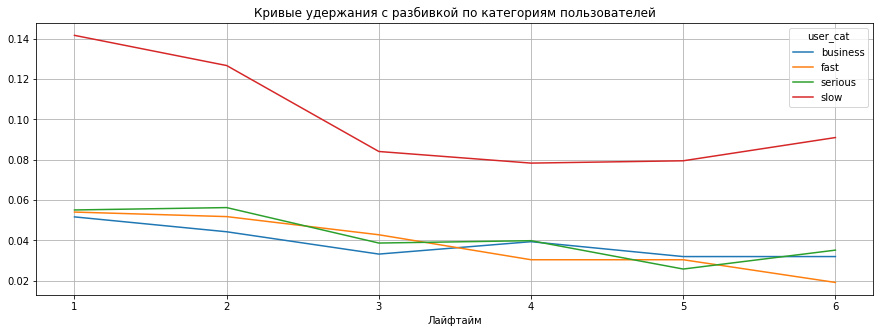

In [62]:
# расчитали удержание для каждой категории пользователей и построили график
retention_raw, retention = get_retention(
    profiles, mobile_df, profiles['first_ts'].max(), horizon_days, dimensions=['user_cat']
)  
report = retention.drop(columns=['cohort_size', 0])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по категориям пользователей')
plt.show()

**Вывод**

Чаще всего возвращаются в приложение пользователи, которые проводят за один сеанс больше 50 минут. Для остальных категорий удержание ниже и мало различается между собой.

### Как различаются пользователи по времени, проведенном в приложении.

Чтобы посчитать время, проведенное пользователем в приложении за весь исследуемый период, сложили длительность всех его сессий. 

In [63]:
# определили полное время проведенное каждым пользователем в приложении за время наблюдения

mobile_tt = mobile_df.groupby('user_id').agg({'interval':'sum'}).rename(columns={'interval': 'total_time'}).reset_index()

#  округлили до целых минут
mobile_tt['total_time']= (mobile_tt['total_time']/60).round()

# присоединили к основной таблице сведения о полном времени
mobile_tt = mobile_df.merge(mobile_tt)

# проверили количество пользователей
print(mobile_tt['user_id'].nunique())

mobile_tt.head()

4144


,user_id,session,start,finish,first_event,last_event,count_event,interval,user_cat,total_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,596.0,business,46.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,507.0,business,46.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30,2019-10-21 20:07:30,tips_show,tips_show,14,900.0,business,46.0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14,2019-10-22 11:30:52,map,tips_show,8,758.0,business,46.0
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33,2019-10-19 21:59:54,search,photos_show,9,1521.0,serious,196.0


In [64]:
print('Минимальное общее время в минутах, проведенное пользователем в приложении', mobile_tt['total_time'].min())
print('Максимальное общее время в минутах, проведенное пользователем в приложении', mobile_tt['total_time'].max())
print('Медианное значение общего времени в минутах, проведенного пользователем в приложении', mobile_tt['total_time'].median())

Минимальное общее время в минутах, проведенное пользователем в приложении 0.0
Максимальное общее время в минутах, проведенное пользователем в приложении 5041.0
Медианное значение общего времени в минутах, проведенного пользователем в приложении 39.0


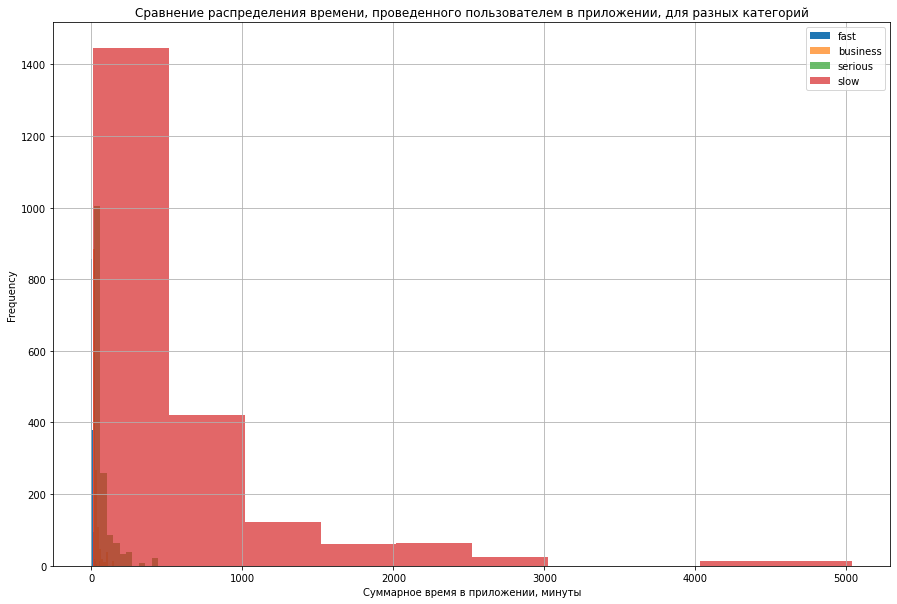

In [65]:
# построили гистограммы распределения полного времени, проведенного в приложении для разных групп
ax = mobile_tt.query('user_cat == "fast"')['total_time'].plot(kind='hist', alpha=1.0, label='fast', legend=True, figsize=(15, 10))
mobile_tt.query('user_cat == "business"')['total_time'].plot(kind='hist',  alpha=0.7, label='business', ax=ax, grid=True, legend=True)
mobile_tt.query('user_cat == "serious"')['total_time'].plot(kind='hist',  alpha=0.7, label='serious', ax=ax, grid=True, legend=True)
mobile_tt.query('user_cat == "slow"')['total_time'].plot(kind='hist', alpha=0.7, label='slow', ax=ax, grid=True, legend=True)

plt.title('Сравнение распределения времени, проведенного пользователем в приложении, для разных категорий')
plt.xlabel('Суммарное время в приложении, минуты')

plt.show()

Посчитали среднее полное время, проведенное в приложении, для пользователей разных категорий. Для этого сложили продолжительность всех сессий данной категории и разделили на количество пользователей в категории. Среднее время перевели в минуты.

In [66]:
user_cat_tt = mobile_df.groupby('user_cat').agg({'user_id': 'nunique', 'interval':'sum'}).reset_index()
user_cat_tt['total_time_mean']  = (user_cat_tt['interval']/ user_cat_tt['user_id']/60).round()
user_cat_tt.rename(columns = {'user_id': 'user_count', 'interval': 'total_time'}, inplace=True)

user_cat_tt.sort_values(by='total_time_mean')

,user_cat,user_count,total_time,total_time_mean
1,fast,1080,287021.0,4.0
0,business,987,949613.0,16.0
2,serious,1045,2724020.0,43.0
3,slow,1032,18304856.0,296.0


Группы пользователей, выделенные на основании характерной для них длительности сессии,  действительно сильно различаются по времени, проведенном в приложении. 

**Вывод**

"Быстрые" обходятся в среднем за 4 минуты в месяц, а самым медленным в среднем надо примерно 5 часов в месяц.

### Как различается частота действий по группам

In [67]:
order = mobile.pivot_table(index='event_name', values='user_id', aggfunc='nunique',).reset_index()
order.columns = ['event', 'user_count']
order['user_ratio'] = (order['user_count'] /len(mobile['user_id'].unique())*100).round(2)
order = order.sort_values('user_count', ascending=False)

order

,event,user_count,user_ratio
7,tips_show,2735,66.00
5,search,1624,39.19
3,map,1426,34.41
4,photos_show,1055,25.46
1,contacts_show,952,22.97
0,advert_open,741,17.88
2,favorites_add,342,8.25
6,tips_click,317,7.65


In [68]:
# закрепили последовательность событий в порядке уменьшения частоты 

#order.index

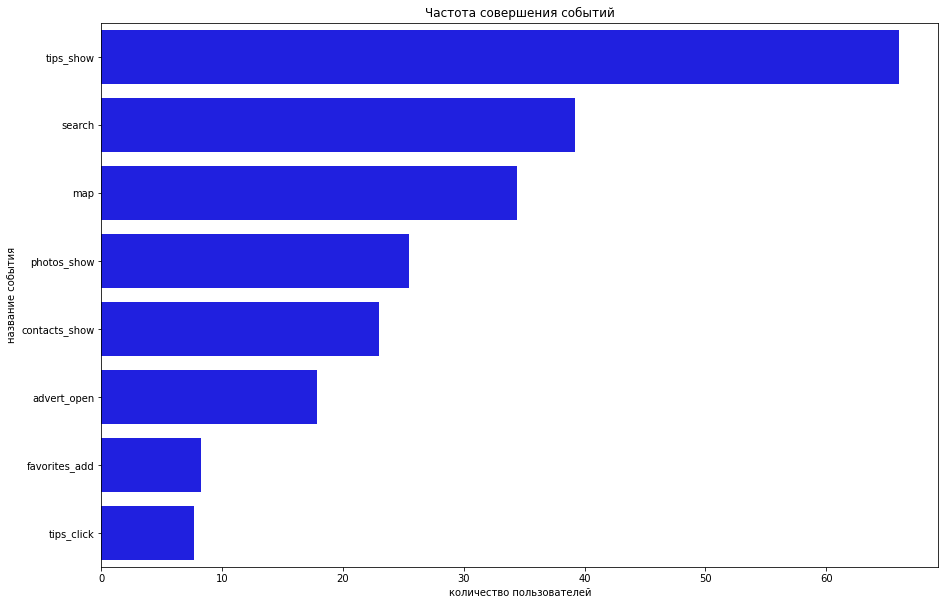

In [69]:
# строим диаграмму частоты событий 
plt.figure(figsize=(15,10))
ax = sns.barplot(x='user_ratio', y='event', data=order, color='blue') 

plt.title('Частота совершения событий')

plt.xlabel('количество пользователей')
plt.ylabel('название события')

plt.show();

In [70]:
# посмотрели число пользователей в каждой из  групп в разрезе событий
df_event = (mobile.pivot_table(
    index='event_name',
    columns='user_cat', 
    values='user_id', 
    aggfunc='nunique')
           .sort_values('fast', ascending=False).reset_index())
df_event = df_event.set_index('event_name')
df_event

user_cat,business,fast,serious,slow
event_name,,,,
tips_show,670,625,736,704
search,377,447,399,401
map,329,313,393,391
photos_show,248,271,254,282
advert_open,175,166,184,216
contacts_show,175,157,238,382
favorites_add,48,59,86,149
tips_click,61,33,90,133


In [71]:
# сщздали колонку с числом пользователей в каждой группе
df_full = mobile.pivot_table(index='user_cat', values='user_id', aggfunc='nunique',).reset_index()
df_full.columns = ['user_cat', 'full']
df_full

,user_cat,full
0,business,987
1,fast,1080
2,serious,1045
3,slow,1032


In [72]:
# повернули таблицу с количеством пользователей по группам и присоединили количество пользователей в группе всего
df_event = df_event.T
df = pd.merge(df_event, df_full, on='user_cat')
df


,user_cat,tips_show,search,map,photos_show,advert_open,contacts_show,favorites_add,tips_click,full
0,business,670,377,329,248,175,175,48,61,987
1,fast,625,447,313,271,166,157,59,33,1080
2,serious,736,399,393,254,184,238,86,90,1045
3,slow,704,401,391,282,216,382,149,133,1032


In [73]:
# посчитали частоту различных действий для каждой группы
df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]] = df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]].div(df.iloc[:, 9].values, axis=0)
df

,user_cat,tips_show,search,map,photos_show,advert_open,contacts_show,favorites_add,tips_click,full
0,business,0.678825,0.381966,0.333333,0.251266,0.177305,0.177305,0.048632,0.061803,987
1,fast,0.578704,0.413889,0.289815,0.250926,0.153704,0.145370,0.054630,0.030556,1080
2,serious,0.704306,0.381818,0.376077,0.243062,0.176077,0.227751,0.082297,0.086124,1045
3,slow,0.682171,0.388566,0.378876,0.273256,0.209302,0.370155,0.144380,0.128876,1032


In [74]:
# посчитали частоту различных действий по группам относительно всей  выборки
funnel = mobile.groupby(['event_name', 'user_cat'])['user_id'].nunique().sort_values(ascending=False).reset_index()

funnel['user_ratio'] = (funnel['user_id'] /len(mobile['user_id'].unique())*100).round(2)
funnel = funnel.sort_values('user_ratio', ascending=False)

funnel

,event_name,user_cat,user_id,user_ratio
0,tips_show,serious,736,17.76
1,tips_show,slow,704,16.99
2,tips_show,business,670,16.17
3,tips_show,fast,625,15.08
4,search,fast,447,10.79
5,search,slow,401,9.68
6,search,serious,399,9.63
7,map,serious,393,9.48
8,map,slow,391,9.44
9,contacts_show,slow,382,9.22


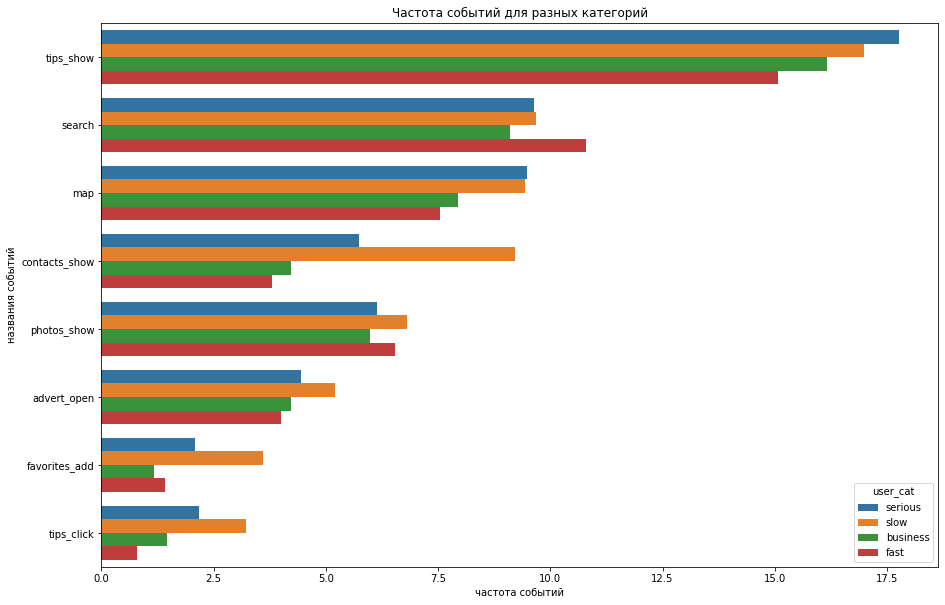

In [75]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(
    x= 'user_ratio', 
    y='event_name', 
    hue='user_cat', 
    data=funnel,
)
    
ax.set(
    title = "Частота событий для разных категорий",
    xlabel = "частота событий",
    ylabel = "названия событий",
    );

**Вывод**

Категории пользователей, сформированные на основании длительности сессии демонстрируют различную частоту действий. 

Рекомендованные объявления, демострируются всем, однако "быстрые" пользователи (меньше 7 минут сессия) видимо умудряются её избегать, ловкость рук. Реже всех открывают рекомендованные объявления.  

И поиск по сайту они совершают чаще всех остальных. Уверенно пользуются приложением. 

Все группы чаще смотрят карты, чем фотографии, добавление в избранное не популярная опция, чаще всего используют "медленные" ( более 50 минут сессия).

"Медленные" чаще всех совершают целевое действие - просмотр контакта, а также больше всех смотрят фотографии, добавляют в избранное, откликаются на рекомендованные объявления. У них на всё хватает времени.

 Синие - "деловые" (от 7 до 17 минут сессия) и зелёные - "серьёзные" (от  17 до 50 минут сессия) демонстрируют похожее поведение по частоте событий. Но из них "серьёзные"  чаще смотрят карты и контакт продавца.
 

### Какие пользователи часто делают целевое событие `contacts_show` - смотрят контакты продавца.

Чтобы построить кривые конверсии для разных категорий пользователей, воспользовались функцией. Профили пользователей уже построили при изучении удержания, момент и горизонт анализа оставили прежними: последний день наблюдения и 7 дней. Данные о времени совершения целевого события получили из таблицы `моbile`. 

In [76]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    mobile,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первого нажатия пользователем  кнопки "посмотреть контактный телефон"
    first_contacts_show = (
        mobile.query('event_name == "contacts_show"').sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_contacts_show[['user_id', 'event_time']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


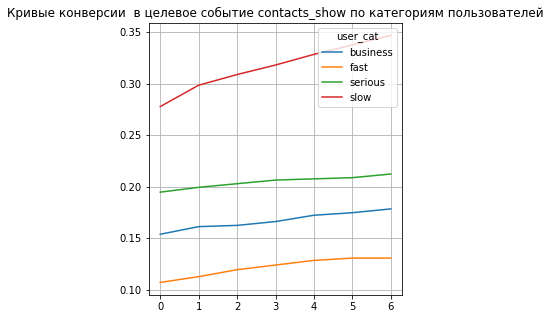

In [77]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, mobile, profiles['first_ts'].max(), horizon_days, dimensions=['user_cat']
)
plt.figure(figsize = (10, 5)) # задаём размер «подложки»

# исключаем размеры когорт

report = conversion.drop(columns = ['cohort_size'])


report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  # во второй — кривые конверсии
plt.title('Кривые конверсии  в целевое событие contacts_show по категориям пользователей')

plt.show() 

**Вывод**

Конверсия в целевое событие "посмотреть контакт" возростает со средней  продолжительностью сессии пользователей. "Медленные лидируют с заметным отрывом.

## Проверка гипотез

### Гипотеза заказчика. Две  группы демонстрируют разную конверсию в просмотры контактов: пришедшие по ссылке из yandex и из google.

Для проверки гипотезы заказчика применили z-test. Убедились, что пользователи не попали более, чем в одну группу. 

In [78]:
mobile.groupby('user_id').agg({'source':'nunique'}).query('source > 1').shape[0]

0

Всё в порядке - каждый пришел из одного источника.


**Нулевая гипотеза:** доли уникальных посетителей из google  и из yandex, совершивших целевое действие, одинаковы.

**Альтенативная гипотеза:** между долями уникальных посетителей из google  и из yandex , совершивших целевое действие, есть значимая разница.


In [79]:
# функциzя для z_testa
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):

    p1 = successes1/trials1

    p2 = successes2/trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [80]:
# подготовили таблицу для теста
df_1 = mobile.groupby('source').agg(user_count=('user_id', 'nunique')).reset_index()
df_2 = mobile.query('event_name == "contacts_show"').groupby('source').agg(user_count=('user_id', 'nunique')).reset_index()
df_source = pd.merge(df_1, df_2, on='source')
df_source

,source,user_count_x,user_count_y
0,google,1097,269
1,other,1179,221
2,yandex,1868,462


In [81]:

z_test(df_source.at[0, 'user_count_y'],df_source.at[2, 'user_count_y'],df_source.at[0, 'user_count_x'],df_source.at[2, 'user_count_x'])

p-значение:  0.8976357028525019
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Гипотеза заказчика не подтвердилась. Не удалось показать, что конверсии в целевое событие "просмотр контакта" различается для тех, кто пришел из google, и тех кто пришел из yandex 

### Собственная гипотеза. Пользователи, завершающие сессию добавлением в избранное или просмотром карты,  демострируют разное удержание.

Нам стало известно, что в приложение недавно добавили новые опции: просмотр фотографий, просмотр геолокации продавца и добавление в избранное. Сделали срезы таблицы mobile_dt по значению признака last_event последнее действие за сессию. Оценили размеры выборок.

In [84]:
mobile_f = mobile_df.query('last_event == "favorites_add"')
mobile_m = mobile_df.query('last_event == "map"')
print('В конце сессии добавили в избранное', mobile_f.shape[0])
print('В конце сессиипосмотрели карту', mobile_m.shape[0])

В конце сессии добавили в избранное 152
В конце сессиипосмотрели карту 194


In [85]:
mobile_f.head()

,user_id,session,start,finish,first_event,last_event,count_event,interval,user_cat
69,030fbe1b-7e5b-49a4-af82-570189847f10,2019-10-15,2019-10-15 10:38:12,2019-10-15 10:40:06,search,favorites_add,3,114.0,fast
177,06b73062-0e64-4e7a-91e7-2c2773234919,2019-10-22,2019-10-22 22:51:47,2019-10-22 23:06:44,search,favorites_add,12,897.0,fast
178,06b73062-0e64-4e7a-91e7-2c2773234919,2019-10-23,2019-10-23 20:44:44,2019-10-23 20:45:47,search,favorites_add,2,63.0,fast
211,07efcf91-4d1a-45c4-aba3-6590bb22ec52,2019-10-17,2019-10-17 19:34:07,2019-10-17 19:41:30,search,favorites_add,2,443.0,slow
228,082fdad3-ec9a-48f6-89c8-ecd28bbc09e0,2019-10-15,2019-10-15 18:08:36,2019-10-15 23:08:15,contacts_show,favorites_add,2,17979.0,slow


In [86]:
profiles.head()

,user_id,first_ts,source,user_cat,event_name,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,other,business,tips_show,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33,yandex,serious,search,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,serious,photos_show,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05,google,business,search,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,business,contacts_show,2019-10-25


Размеры выборок маловаты для оценки статистической значимости. Но решили попробовать.

In [87]:
# расчитали удержание для завершающих сессию добавлением в избранное 

retention_raw, retention = get_retention(
    profiles, mobile_f, profiles['first_ts'].max(), horizon_days, dimensions=['source']
)  
test_f = retention.drop(columns = ['cohort_size'])
test_f = test_f.T
test_f

source,google,other,yandex
0.0,0.020879,0.012645,0.020473
1.0,0.000000,0.000000,0.002559
2.0,0.002198,0.002107,0.003199
3.0,0.001099,0.001054,0.001919
4.0,0.000000,0.001054,0.002559
5.0,0.002198,0.002107,0.001919
6.0,0.002198,0.002107,0.000000


In [88]:
# рассчитали удержание для завершающих сессию просмотром карты
retention_raw, retention = get_retention(
    profiles, mobile_m, profiles['first_ts'].max(), horizon_days, dimensions=['source']
)  
test_m = retention.drop(columns = ['cohort_size'])
test_m = test_m.T
test_m

source,google,other,yandex
0.0,0.024176,0.045311,0.035189
1.0,0.001099,0.002107,0.003199
2.0,0.000000,0.003161,0.002559
3.0,0.001099,0.002107,0.001919
4.0,0.000000,0.002107,0.001919
5.0,0.000000,0.000000,0.001919
6.0,0.000000,0.000000,0.000640


In [89]:
test_m['yandex']

0.0    0.035189
1.0    0.003199
2.0    0.002559
3.0    0.001919
4.0    0.001919
5.0    0.001919
6.0    0.000640
Name: yandex, dtype: float64

Все допущения, сделанные при  проверке предыдущей гипотезы остаются в силе. Для проверки гипотезы о неравенстве удержания взяли пользователей из yandex.

Нулевую гипотезу Н0 сформулируем так: "Удержание пользователей, скачавших приложение из yandex, завешающих сессию добавлением в избранное или просмотром карты, однаковое" Пороговое значение установили 0.005. Если вероятность получить данные, не противоречащие нулевой гипотезе, будет выше 0.005, то утверждение о равенстве удержания пользователей  имеет право на существование.

Альтернативная гипотеза H1: "Удержание пользователей, скачавших приложение из yandex, завешающих сессию добавлением в избранное или просмотром карты, различное". Если вероятность получить данные, не противоречащие гипотезе о равенстве удержания двух разных завершений сессии будет меньше порогового значения, то нулевую гипотезу надо отвергнуть. Предположение  о различии удержания  для пользователей с разными завершающими сессию событиями является обоснованной.

In [91]:
alpha = .005
results = st.ttest_ind(test_f['yandex'], test_m['yandex'], equal_var=False)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение: 0.707870639891677
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Наша теория тоже не подтвердилась, возможно из-за маленьких выборок, а возможно, что те, кто вчера посмотрел карту и те, кто добавил в избранное с одинаковой вероятностью вернуться в приложение позже.

## Выводы

Проведено исследование данных о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. Последняя дата наблюдения 3 ноября 2019 года.

После очистки данных от неявных дубликатов и случайных событий (длительность сессии меньше секунды) и аномально длинных событий (сессия длиннее 9 часов), остались сведения о 4144 пользователе.

В целях исследования установили, что одна сессия - это все события, совершенные в течение суток. Длительность сессии определили, как интервал между первым и последним событием за сутки.

Разделили пользователей на 4 приблизительно равные категории исходя из длительности сессии:
- до 7 минут (420 секунд)                   fast    1080 пользователей; 
- от 7 до 17 минут(421 - 1020 секунд)       business 987 пользователей;
- 17 минут до 50 минут (1021 - 3000 секунд) serious 1045 пользователей;
- больше 50 минут (3001 )                   slow    1032 пользователя.

Группы не совсем равного размера из-за округления граничных значений до минут.

Самые короткие сессии 1 секунда, самые длинные после отсечения аномальных около 9 часов. Пользователи совершают за одну сессию от 2 до  170 событий, но в общем виде рост продолжительности сессии не приводит к увеличению количества совершенных внутри неё событий. Бурная деятельность наблюдается на коротких сессиях.

Ежедневно в среднем приложением пользуется (DAU) 272 человека, из них 59 быстрых, 56 деловых, 61 серьёзный  96 медленных. С учетом равенства групп, медленные посещают приложение чаще.

Количество сессий одного пользователя за исследованный период варьируется от 1 до 25. Большинство пользователей посетили приложение 1 раз за исследуемый период. расчитали `retention` и построили кривые удержания для каждой категории, выяснили, что удержание пользователей, которые проводят в приложении в среднем более 50 минут в день, сильно превосходит остальные категории.
**"Медленные" чаще других склонны возвращаться.**

Чтобы посчитать **время, проведенное пользователем в приложении за весь исследуемый период,** сложили длительность всех его сессий. Минимальное время меньше 1 минуты, максимальное время 84 часа (это больше 3 часов ежедневно - барахольщик), медианное значение времени, проведенного пользователем в приложении 39 минут за весь период. По показателю общего времени, проведенного в приложении за исследуемый период категории пользователей распределились следующим образом: fast 4 минуты, business 16 минут, serious 43 минуты, slow 296 минут (почти 5 часов).

**Частота совершаемых действий** имеет свои особенности для разных категорий пользователей. Рекомендованные объявления, демострируются всем, однако "быстрые" пользователи умудряются её избегать, реже всех открывают рекомендованные объявления.  
И поиск по сайту они совершают чаще всех остальных. Уверенно пользуются приложением. Но целевое действие "просмотр контактов" совершают реже всех. "Медленные" чаще всех совершают целевое действие - просмотр контакта, а также больше всех смотрят фотографии, добавляют в избранное, откликаются на рекомендованные объявления. У них на всё хватает времени.  "Деловые" (от 7 до 17 минут сессия) и "серьёзные" (от  17 до 50 минут сессия) демонстрируют похожее между собой поведение по частоте событий. Но из них "серьёзные"  чаще смотрят карты и контакт продавца.
Все группы чаще смотрят карты, чем фотографии, добавление в избранное не популярная опция, чаще всего ею пользуются "медленные" ( более 50 минут сессия).
На рекомендованные объявления чаще всех кликают "медленные" пользователи.

Для ответа на вопрос **"Какие пользователи часто делают целевое событие `contacts_show` - смотрят контакты продавца?"** построили кривые конверсии в целевое событие. По мете увеличения продолжительности сессии конверсия в группе растёт, но группа "медленных" пользователей лидирует с существенным отрывом.
 
 **Проверка предложенной гипотезы.** Не удалось показать, что конверсии в целевое событие "просмотр контакта" различается для тех, кто пришел из google, и тех кто пришел из yandex.
**Прверка собственной гипотезы.** Не удалось показать, что пользователи, завершающие сессию добавлением в избранное или просмотром карты, демострируют разное удержание. Выборки пользователей с нужными признаками оказались слишком маленькими.
 
По результатам провденного исследования обратили внимание на следующие аспекты функционирования приложения:
 -  показ рекомендованных объявлений подавляющее большинсто пользователей игнорируют;
 -  целевой аудиторией приложения являются "медленные" пользователи, длительность одной сессии у них более 50 минут, их ежедневное присутствие составляет 35% от общего числа присутствующих, а размер группы 25% всех пользователей. Среди них есть товарищи, посещавшие приложение 25 дней из 28, удержание на шестой день составляе 9%, другие группы меньше 4%. Они чаще всего откликаются на рекомендованные объявления, а конверсия в целевое действие на шестой день достигает 35%, для сравнения у "быстрых" 13%;
 - выбранный критерий для категоризации покупателей (продолжительность сессии) характеризует особенности поведения пользователя, его заинтересованность в приобретении чего-то, умение обращаться с приложением, наличие свободного времени, ловкость пальцев,  наконец. 
 - мы исследовали данные о пользователях, которые покупают ненужные вещи. Полагаем, что полезно будет сопоставить сведения о покупателях со сведениями о продавцах. Увеличение числа посещений при росте продолжительности сессии и снижении количества действий, совершенных внутри одной сессии, может означать, что в этой категории много пользователей, которые что-то продают в приложении.
  